In [1]:
from pathlib import Path
from pyfishsensedev.image import ImageRectifier, RawProcessor
from transformers import pipeline
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pyfishsensedev.image.image_processors.raw_processor_old import RawProcessorOld
from pyfishsensedev.calibration import LensCalibration, LaserCalibration
from pyfishsensedev.laser.nn_laser_detector import NNLaserDetector
from pyfishsensedev.depth_map import LaserDepthMap

from pyfishsensedev.library.seathru import estimate_sigma, denoise_tv_chambolle, run_pipeline

In [2]:
def uint8_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 255

def uint16_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 65535

def double_2_uint8(img: np.ndarray) -> np.ndarray:
    return (img * 255).astype(np.uint8)

def uint16_2_uint8(img: np.ndarray) -> np.ndarray:
    return double_2_uint8(uint16_2_double(img))

def imshow(img: np.ndarray | Image.Image):
    if hasattr(img, "dtype"):
        arr = img
    elif isinstance(img, Image.Image):
        arr = np.array(img)

    if arr.dtype == np.uint16:
        arr = uint16_2_uint8(img)
    elif arr.dtype == float:
        arr = double_2_uint8(arr / arr.max())

    plt.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))

In [3]:
ORF_FILE = Path("/mnt/fishsense_data/REEF/data/2023.08.03.FishSense.FSL-01D/H slate dive 1/P8030006.ORF")
LENS_CALIBRATION_FILE = Path("./data/lens-calibration.pkg")
LASER_CALIBRATION_FILE = Path("./data/laser-calibration.pkg")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
lens_calibration = LensCalibration()
lens_calibration.load(LENS_CALIBRATION_FILE)

laser_calibration = LaserCalibration()
laser_calibration.load(LASER_CALIBRATION_FILE)

In [6]:
raw_process = RawProcessor(ORF_FILE)
dark_raw_processor = RawProcessorOld(Path(ORF_FILE), enable_histogram_equalization=False)

image_rectifier = ImageRectifier(lens_calibration)

img = next(raw_process.__iter__())
img = image_rectifier.rectify(img)

img_dark = next(dark_raw_processor.__iter__())
img_dark = image_rectifier.rectify(img_dark)

img8 = uint16_2_uint8(img)
img_dark8 = uint16_2_uint8(img_dark)

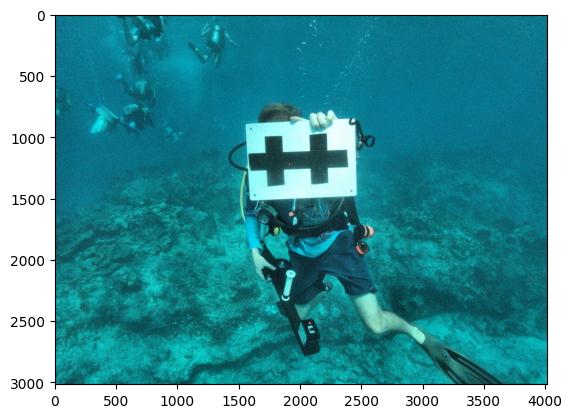

In [7]:

imshow(img)

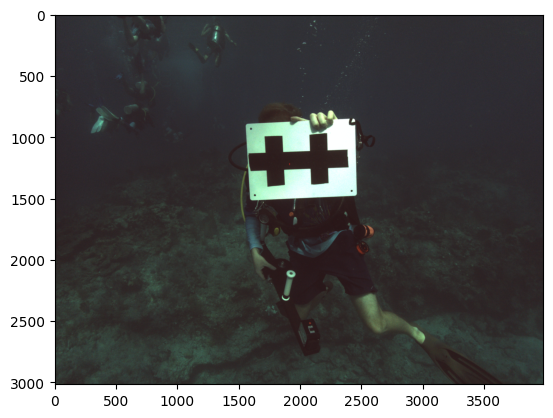

In [8]:
imshow(img_dark)

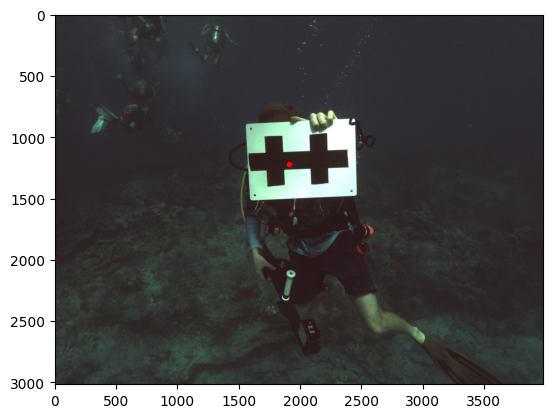

In [9]:
laser_detector = NNLaserDetector(lens_calibration, laser_calibration, device)
laser_coords = laser_detector.find_laser(img_dark8)
laser_coords_int = np.round(laser_coords).astype(int)

imshow(img_dark8)
plt.plot(laser_coords[0], laser_coords[1], 'r.')
plt.show()

In [10]:
depth_map = LaserDepthMap(laser_coords, lens_calibration, laser_calibration)
laser_depth = depth_map.depth_map[0, 0]

laser_depth

np.float64(0.8092308482255313)

In [11]:
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf", device=device)

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

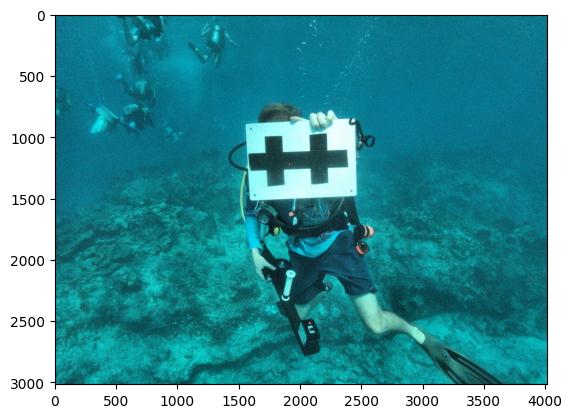

In [12]:
image = Image.fromarray(uint16_2_uint8(img))

imshow(image)

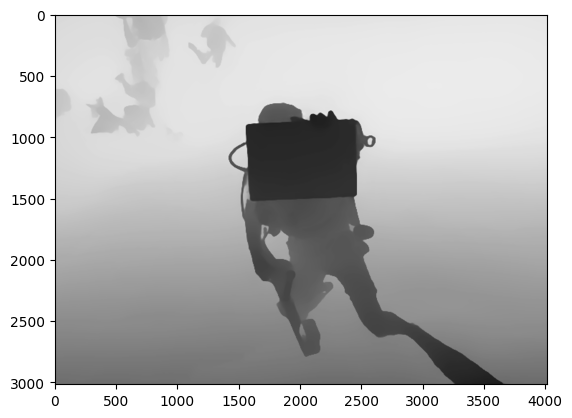

In [13]:
depth = 255 - np.array(pipe(image)["depth"], dtype=float)
scale = laser_depth / depth[laser_coords[1], laser_coords[0]]

depth *= scale

imshow(depth)

In [14]:
class Args:
    def __init__(self, depth: np.ndarray):
        self.f = 2.0
        self.l = 0.5
        self.p = 0.01
        self.min_depth = 0
        self.max_depth = depth.max()
        self.spread_data_fraction = 0.05

    def __iter__(self):
        return self.__dict__.__iter__()

In [15]:
depth[laser_coords[1], laser_coords[0]]

np.float64(0.8092308482255313)

In [ ]:

recovered = run_pipeline(uint16_2_double(img), depth, Args(depth))

imshow(recovered)

Estimating backscatter...
Finding backscatter coefficients...
Constructing neighborhood map...


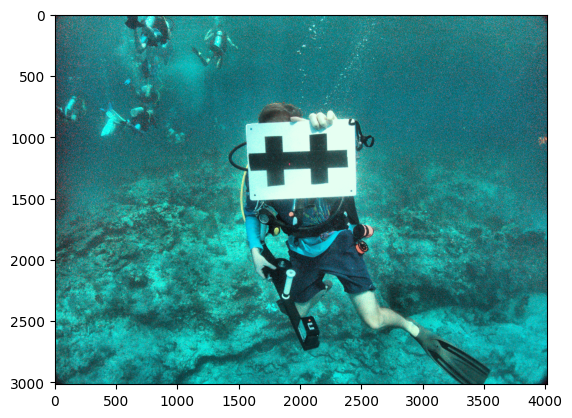

In [ ]:

sigma_est = estimate_sigma(recovered, channel_axis=2, average_sigmas=True) / 10.0

imshow(recovered)

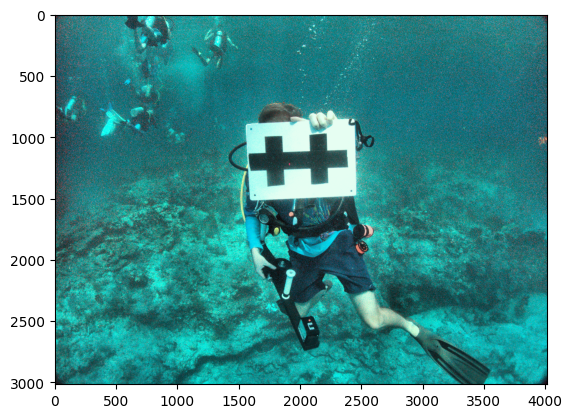

In [ ]:

recovered = denoise_tv_chambolle(recovered, sigma_est, channel_axis=2)

imshow(recovered)